# Text analysis for stock market prediction

In this part of my project I use the pre-trained BERT model to analyse the sentiment of over 48000 news articles that I have collected. To do this I train the BERT model on a set of approximately 5000 sentiment labelled stock market news articles. I will then use this fine tuned model to predict the sentiment on my articles.

<br>

This model is 85% accurate at understanding the sentiment of news articles


In [2]:
import re 
import datetime
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer


from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix

stop_words = set(stopwords.words('english'))

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
Using TensorFlow backend.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
file = open('drive/My Drive/text.csv','r',encoding='UTF-8')
File = open('drive/My Drive/stocks_name.txt','r')

Name = []
Codes = []
Type = []
Add = []

for line in File:
    line = re.sub('\n', '', line)
    line = line.split('\t')
    Name.append(re.sub(' ', ' ',line[0].lower())+' ')
    Type.append(line[2])
    Add.append(line[1].lower()+ ' ')
    if line[1][2:4] == '.A':
        Codes.append('BT-A.L')
    elif line[1][2] == '.':
        Codes.append(line[1] + 'L')
    else:
        Codes.append(line[1] + '.L')

a=0
le = 0
for line in file:
    line = line.split(']')
    #print(line)
    #print(len(line))
    a+=len(line)
    le += 1
    if le == 3:
        h = line

print(le)
    
print('Total number of articles : ', a)

99
Total number of articles :  48631


This is builds a collection of very specific words that are hard to train on so they will be replaced with the word company. This will hopefully produce better results.

In [6]:
A = ['admiral ','anglo american ','ashtead ' ,'auto trader ','bae ','barratt ','berkeley ','berkeley group ','american tobacco ',
     'british tobacco ','bt ','carnival corporation ','coca cola ','cola ','coke ','cocacola ','compass ','crh ','croda ','dcc ','ferguson ',
    'flutter ','intercontinental hotels ','hargreaves ','lansdown ','hikma ','international airlines ','airlines group ','itv ','jd ',
     'kingfisher ','legal general ','lloyds ','lloyds banking ','lse ','london stock exchange ','mg ','melrose ','national grid ','nmc ',
     'pearson ','persimmon ','pheonix ','polymetal ','predential ','reckitt ','benckiser ','rentokil ','rio tinto ','rolls royce ','rolls-royce ',
    'rollsroyce ','rbs ','bank of scotland ','shell ','dutch shell ','rsa ','rsa insurance ','sage ','sainsburys ','scottish mortgage investment ',
    'scottish mortgage ','smith nephew ','smith ','smiths ','ds ','smurfit ','kappa ','pirax sarco ','pirax sarco engineering ','sse ',
    'standard life ','st jamess ','st james ','st. jamess place ','st. james place ','taylor ','wimpey ','tui ','vodafone ','wpp ','3is ']
As = []
for word in A:
    As.append(word[:-1]+'s ')
Name = Name + A + Add + As
print(len(Name))
#need plural of all above

364


This part of the code generates a label for each of the news articles collected for the companies in the FTSE 100 based on how the stock price changed between the morning of the article being posted and the close 2 days later.

In [7]:
file = open('drive/My Drive/text.csv','r',encoding='UTF-8')

DataFrame = pd.DataFrame()

a=0
le = 0

for line in file:
    line = line.split(']')
    le += 1
        
    sentence = []
    date = []

    for i in line:
        i = i.split('xa0')
        s=re.sub(r'-', ' ',i[0].lower())
        s=re.sub(r'[^a-z ]', '', s) #removing number doesnt do much to improve 
        s=re.sub('ftse 100','shares',s)
        s=re.sub('ftse','shares',s)
        s=re.sub('investingcom united kingdom','',s)

        big_regex = re.compile('|'.join(map(re.escape, Name))) #removes the company names
        s = big_regex.sub("company ", s)

        words = s.split()
        words = [word for word in words if word not in stop_words] #removes stop words
        content = ' '.join([lemmatizer.lemmatize(word) for word in words]) #reduces every word to its stem
        sentence.append(content)

        try:
            dat = re.sub(r'[^A-Za-z0-9 ]', '', i[-1])
            dat = re.sub(' ', '-', dat)
            dat = datetime.datetime.strptime(dat, '%b-%d-%Y')
            date.append(dat)
        except:
            dat = '27-03-2020'
            dat = datetime.datetime.strptime(dat, '%d-%m-%Y')
            date.append(dat)

    if len(date) != len(sentence):
        print(le)
        break
        
    sentence = sentence[:-2]
    date = date[:-2]

    dF = pd.DataFrame(date)
    dF.columns = ['Date']
    dF['sent'] = sentence
    dF = dF.sort_values('Date')
    dF.set_index('Date', inplace=True)

    DF = pd.read_csv('drive/My Drive/csv/' + Codes[le-1] + '.csv')

    # Sort DataFrame by date
    DF = DF.sort_values('Date')
    DF.set_index('Date', inplace=True)
    
    delay = 2
    percent = []
    for i in range(len(DF['Close'])-delay):
        percent.append((DF['Close'][i+delay] - DF['Open'][i])/DF['Open'][i])
        
    for i in range(len(DF['Close'])-len(percent)):
        percent.append(0)
        
    DF['percent'] = percent

    data = pd.merge(DF,dF, how='right', left_index=True, right_index=True)
    data = data.fillna(0)
    data = data.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1)
    #print(data.tail(10))
    
    DataFrame = DataFrame.append(data)
    print(len(DataFrame))


104
244
1389
1894
2110
2435
3274
3301
3334
3361
3933
4437
8424
8867
9036
9914
12303
12908
13005
13508
13620
14013
14490
15056
15202
15344
15523
15556
15625
16106
17038
17069
17142
17289
17456
18040
19399
19434
20014
21931
22226
22673
22727
22918
24130
24201
24895
24980
25113
25165
25515
25606
25864
27668
28237
28277
28409
28483
28639
29139
29502
29799
30081
30489
31192
31713
31781
31972
32785
33059
33142
33208
34198
34928
36875
39453
39610
39743
40376
40644
40663
40691
40827
40987
41087
41141
41169
41679
42857
43319
43414
43858
45437
45765
46651
46776
47703
47968
48433


For future testing I combine the data from the most recent 10 news articles to build up a better picture of the company.

In [8]:
trial = DataFrame
trial.tail()
percent = trial['percent']

binary = []
for p in percent:
    if p < 0:
        binary.append(0)
    else:
        binary.append(1)

sent = trial['sent']

trial = trial.drop(columns = ['percent'])
trial['binary'] = binary

trial.head()

articles = 10

full = []
new_sent = []
for i in range(len(list(sent))):
    
    if sent[i] != 0:
        new_sent.append(sent[i])        
      
    if len(new_sent) == 0:
        full.append(0)
    elif len(new_sent) > articles:
        new_sent = new_sent[-articles:]
        full.append(new_sent)
    else:
        full.append(new_sent)
    


Full = []
for f in full:
    string = str(f)
    Full.append(re.sub(r'[^a-z0-9 ]', '', string))


In [9]:
trial['full'] = Full
trial.head(1001)

,sent,binary,full
Date,,,
2014-09-22,electra say criticism activist bramson beggar ...,0,electra say criticism activist bramson beggar ...
2014-11-13,britain see return rise say need fresh funcompany,1,electra say criticism activist bramson beggar ...
2014-12-11,weaker miner push share five week low,0,electra say criticism activist bramson beggar ...
2014-12-18,sncf mull buyout uk government eurostar stake ...,1,electra say criticism activist bramson beggar ...
2015-01-29,uk private equity firm keen sell asset yield h...,1,electra say criticism activist bramson beggar ...
...,...,...,...
2018-07-25,mining share drag share lower company shine,1,uk share lower close trade uk share higher clo...
2018-07-26,de beer size canadian diamond project first bi...,0,uk share higher close trade company tintos min...
2018-07-27,explainer indian billionaire anil agarwals mov...,1,company tintos mineral sancompany operation so...


In [10]:
print(Full[100])
print(sentence[9])


forget bitcoin think high yield share stock supercharge portfolio short seller wouldnt touch share dividend stock thats im buying uk share lower close trade uk share higher close trade uk share higher close trade uk share lower close trade private equity firm post half year return share inch lower drop offset company surge istanbul talk metro funding new mayor visit london source uk share lower close trade infrastructure sell uk project portfolio million
share sink lower oil major hit crude price slide


# **I will now train BERT to understand the sentiment** 




From now on I will build a model that models the sentiment, I will use labled financial news articles that have been to train the BERT model and then I will be able to use it on my dataset.


In [11]:
file = open('drive/My Drive/Sentences_66Agree.txt', 'r', encoding = "ISO-8859-1")
sentiment = []
train_sent = []
length = 0
for line in file:
    line = line.split('@')
    sentiment.append(line[1][:-1])
    s=re.sub(r'-', ' ',line[0].lower())
    s=re.sub(r'[^a-z0-9 ]', '', s) #removing number doesnt do much to improve 
    words = s.split()
    words = [word for word in words if word not in stop_words] #removes stop words
    content = ' '.join([lemmatizer.lemmatize(word) for word in words]) #reduces every word to its stem
    train_sent.append(content)
    length +=1
print(len(sentiment))
print(len(train_sent))
print(sentiment[1])
print(train_sent[1200])

4217
4217
neutral
server responsible managing device user account desktop client application enables remote access mobile phone


In [12]:
i=0
for sent in sentiment:
    if sent == 'neutral':
        i+=1
print(i)

2535


In [13]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')
    
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [14]:
!pip install transformers
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

     |████████████████████████████████| 757kB 2.6MB/s 
     |████████████████████████████████| 890kB 13.1MB/s 
     |████████████████████████████████| 1.1MB 16.7MB/s 
     |████████████████████████████████| 3.0MB 21.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=c8a5f34a8a971bd7cf09917ea256b64972a18b22a93725648bf2d466f1888395
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
Loading BERT tokenizer...


In [15]:
sentence = train_sent
label = sentiment
binary = []

for i in sentiment:
    if i == 'negative':
        binary.append(0)
    elif i == 'positive':
        binary.append(2)
    else:
        binary.append(1)

In [16]:
# Print the original sentence.
print(' Original: ', sentence[1000])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentence[1000]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentence[1000])))

 Original:  according finnair technical service measure due employment situation
Tokenized:  ['according', 'finn', '##air', 'technical', 'service', 'measure', 'due', 'employment', 'situation']
Token IDs:  [2429, 9303, 11215, 4087, 2326, 5468, 2349, 6107, 3663]


May want to change "ftse 100" to "index" so its tokenized as one word 
remove all numbers?

In [17]:
print(type(sentence))
print(len(sentence))

<class 'list'>
4217


In [18]:
max_len = 0
# For every sentence...
for sent in sentence:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  111


In [19]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentence:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 50,         # Pad & truncate all sentences.
                        truncation = True,
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(binary)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentence[100])
print('Token IDs:', input_ids[100])

Original:  net sale increased eur655m april june 2010 eur438m year earlier
Token IDs: tensor([  101,  5658,  5096,  3445,  7327,  2099, 26187,  2629,  2213,  2258,
         2238,  2230,  7327,  2099, 23777,  2620,  2213,  2095,  3041,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


In [20]:
#labels = trial.binary.values

#labels = torch.tensor(np.array(binary))
print(len(input_ids))

4217


In [21]:
from torch.utils.data import TensorDataset

print(len(input_ids),len(labels))


# Shuffling the data 

from sklearn.utils import shuffle
input_ids, attention_masks, labels = shuffle(input_ids, attention_masks, labels, random_state=0)


# Combine the training inputs into a TensorDataset.
split = 3000
test = 700
val = 300
train_dataset = TensorDataset(input_ids[:split], attention_masks[:split], labels[:split])
val_dataset = TensorDataset(input_ids[split:split + val], attention_masks[split:split + val], labels[split:split + val])
test_dataset = TensorDataset(input_ids[split + val:], attention_masks[split + val:], labels[split + val:])
# Create a 90-10 train-validation split.
print(len(test_dataset))
print(labels[:split])

p=0
n=0
neu=0
b=0
for l in labels[split:split+val]:
  if l == 1:
    neu+=1
  elif l ==0:
    n+=1
  elif l==2:
    p+=1
  else:
    b+=1
print(neu,n,p,b)

4217 4217
917
tensor([1, 1, 1,  ..., 0, 2, 1])
173 52 75 0


In [22]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = SequentialSampler(train_dataset), # Select batches sequentially
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [24]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [25]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [27]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [28]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [29]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 4 ========
Training...
  Batch    40  of     94.    Elapsed: 0:00:20.
  Batch    80  of     94.    Elapsed: 0:00:41.

  Average training loss: 0.79
  Training epcoh took: 0:00:47

Running Validation...
  Accuracy: 0.75
  Validation Loss: 0.62
  Validation took: 0:00:02

======== Epoch 2 / 4 ========
Training...
  Batch    40  of     94.    Elapsed: 0:00:20.
  Batch    80  of     94.    Elapsed: 0:00:41.

  Average training loss: 0.45
  Training epcoh took: 0:00:48

Running Validation...
  Accuracy: 0.81
  Validation Loss: 0.50
  Validation took: 0:00:02

======== Epoch 3 / 4 ========
Training...
  Batch    40  of     94.    Elapsed: 0:00:20.
  Batch    80  of     94.    Elapsed: 0:00:41.

  Average training loss: 0.28
  Training epcoh took: 0:00:48

Running Validation...
  Accuracy: 0.83
  Validation Loss: 0.48
  Validation took: 0:00:02

======== Epoch 4 / 4 ========
Training...
  Batch    40  of     94.    Elapsed: 0:00:20.
  Batch    80  of     94.    Elapsed: 0:

In [30]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.79,0.62,0.75,0:00:47,0:00:02
2,0.45,0.50,0.81,0:00:48,0:00:02
3,0.28,0.48,0.83,0:00:48,0:00:02
4,0.21,0.48,0.83,0:00:48,0:00:02


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


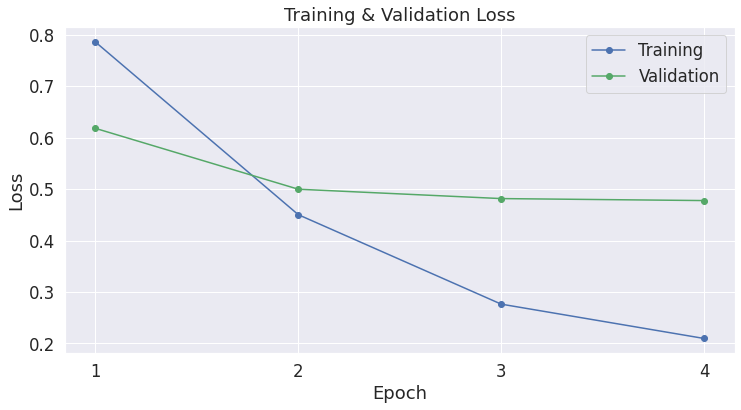

In [31]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Testing


In [38]:
#@title Default title text
import pandas as pd
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

NameError: ignored

In [40]:
# Prediction on test set

prediction_dataloader = DataLoader(
            test_dataset,  # The training samples.
            sampler = SequentialSampler(test_dataset), # Select batches sequentially
            batch_size = batch_size # Trains with this batch size.
        )


print('Predicting labels for {:,} test sentences...'.format(len(test_dataset)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 917 test sentences...
    DONE.


In [51]:
pred_labels = []
for i in range(len(true_labels)):
  pred_labels.append(np.argmax(predictions[i], axis=1).flatten())

pred_labels = np.concatenate(pred_labels)
true_labels = np.concatenate(true_labels)

for i in range(len(pred_labels)):
  if pred_labels[i] == true_labels[i]:
    a += 1
print('Accuracy : ', a/len(true_labels))

Accuracy :  0.8516902944383861


# This model is 85% accurate at understanding the sentement of a finiancial news article 

In [42]:
#print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


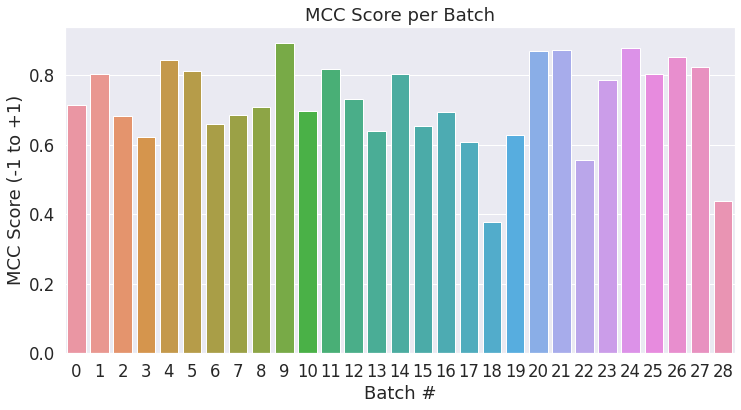

In [43]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [37]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.727


# Saving the model


In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save_BERT/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Cite: Chris McCormick and Nick Ryan. (2019, July 22). BERT Fine-Tuning Tutorial with PyTorch. Retrieved from http://www.mccormickml.com